 # Drive Mount

In [1]:
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Colab\ Notebooks/_dev_matching

/content/drive/MyDrive/Colab Notebooks/_dev_matching


In [3]:
!ls

ckpt  data  dataset.py	main.ipynb  models.py  __pycache__  Untitled


# Install Libraries

In [10]:
!pip install timm

     |████████████████████████████████| 348kB 14.0MB/s 


In [11]:
! pip install albumentations==0.4.6

     |████████████████████████████████| 122kB 14.3MB/s 
     |████████████████████████████████| 952kB 26.3MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp37-none-any.whl size=65163 sha256=fa1fe4fb586a808fbb710d4fd2c3571319d4fbd0729b0c321522e9d458ca9496
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


# Data Preparation

In [4]:
from glob import glob

label_dict = {
    'dog' : 0,
    'elephant' : 1,
    'giraffe' : 2,
    'guitar' : 3,
    'horse' : 4,
    'house' : 5,
    'person' : 6
}

data_paths = glob("./data/train/*/*")

In [5]:
label2class = {v:k for k, v in label_dict.items()}

In [6]:
len(data_paths)

1698

In [7]:
paths_w_label = [(x, label_dict[x.split("/")[-2]]) for x in data_paths]

In [8]:
for i in range(0, 1000, 240):
    print(paths_w_label[i])

('./data/train/elephant/pic_156.jpg', 1)
('./data/train/house/pic_272.jpg', 5)
('./data/train/dog/pic_329.jpg', 0)
('./data/train/dog/pic_040.jpg', 0)
('./data/train/giraffe/pic_101.jpg', 2)


In [9]:
X = [x[0] for x in paths_w_label]
Y = [x[1] for x in paths_w_label]

In [10]:
import numpy as np
from sklearn.model_selection import StratifiedKFold


X = np.array(X)
Y = np.array(Y)

skf = StratifiedKFold(n_splits=5, shuffle=True)

folded = [(x, y) for x, y in skf.split(X, Y)]

In [11]:
folded = {'fold'+str(i):{'train':(X[idx[0]].tolist(), Y[idx[0]].tolist()), 'test':(X[idx[1]].tolist(), Y[idx[1]].tolist())} for i, idx in enumerate(folded)}

In [12]:
folded['fold0']['test'][0][:5]

['./data/train/elephant/pic_156.jpg',
 './data/train/elephant/pic_154.jpg',
 './data/train/elephant/pic_167.jpg',
 './data/train/elephant/pic_172.jpg',
 './data/train/elephant/pic_114.jpg']

In [13]:
folded['fold0']['test'][1][:5]

[1, 1, 1, 1, 1]

# Define Functions

In [14]:
from models import *
from dataset import *
from torch.utils.data import DataLoader
import torch
from tqdm.notebook import tqdm

from torch import nn

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

In [15]:
def show_result(model, test_dataset, device, is_labeled=True):
    model.eval()
    fig = plt.figure(figsize=(12, 12))
    tmp_iter = DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=4)
    for i, b in enumerate(tmp_iter):
        if is_labeled:
            imgs, _, img_paths = b
        else:
            imgs, img_paths = b
        imgs = imgs.to(device)
        logits = model(imgs)['logits']
        _, output = torch.max(logits, 1)
        break
    for i in range(4):
        img = cv2.imread(img_paths[i])
        subplt = fig.add_subplot(2, 2, i+1)
        subplt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        subplt.set_title(f"{img_paths[i]} / {label2class[int(output[i].detach().cpu())]}")
        subplt.axis("off")
    plt.show()

In [16]:
def train_epoch(model, train_loader, val_loader, epochs, optimizer, device):
    print(f"=========== START TRAIN EPOCH {epochs} ===========")
    print()
    criterion = nn.CrossEntropyLoss()
    model.train()
    model = model.to(device)
    train_loss = []
    bar = tqdm(train_loader)
    for batch in bar:
        imgs, y_true, _ = batch
        imgs = imgs.to(device)
        y_true = y_true.to(device)
        
        optimizer.zero_grad()

        logits = model(imgs)['logits']
        loss = criterion(logits, y_true)
        loss.backward()
        optimizer.step()

        loss_np = loss.detach().cpu().numpy()
        train_loss.append(loss_np)
        # bar.set_description('loss: %.5f, arcface_s: %.5f' % (loss_np, s))
    
    train_loss = np.mean(train_loss)

    print(f"=========== START VALID EPOCH {epochs} ===========")
    print()
    model.eval()
    val_loss = []
    bar = tqdm(train_loader)

    correct = [0]*7
    pred_total = [0]*7

    for batch in bar:
        imgs, y_true, _ = batch
        imgs = imgs.to(device)
        y_true = y_true.to(device)

        logits = model(imgs)['logits']
        loss = criterion(logits, y_true)

        loss_np = loss.detach().cpu().numpy()
        val_loss.append(loss_np)

        _, y_pred = torch.max(logits, 1)
        y_pred = y_pred.cpu().tolist()
        y_true = y_true.cpu().tolist()
        for i in range(len(y_pred)):
            pred_total[y_pred[i]] += 1
            if y_pred[i]==y_true[i]:
                correct[y_pred[i]] += 1
    
    total_correct = 0
    N = 0
    for i in range(7):
        print(f"\tclass {i} PRECISION: {correct[i]/(pred_total[i]+1e-4):.4f}")
        total_correct += correct[i]
        N += pred_total[i]
    print(f"\t\ttotal precision: {total_correct/N:0.4f}")
    print(f"epoch {epochs} DONE.")
    return train_loss, val_loss, total_correct/N



# Env Setting

In [17]:
print("PyTorch version:[%s]."%(torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device:[%s]."%(device))
EPOCHS = 10

PyTorch version:[1.8.1+cu101].
device:[cuda:0].


In [18]:
args = {
    'backbone': 'tf_efficientnet_b3_ns',
    'p_trainable': False,
    'embedding_size': 256,
    'n_classes': 7,
}

transforms = get_transforms()

# Train Fold 0

In [19]:
model = Net(args=args)

In [20]:
train_data_fold0 = folded['fold0']['train'][0]
train_label_fold0 = folded['fold0']['train'][1]

test_data_fold0 = folded['fold0']['test'][0]
test_label_fold0 = folded['fold0']['test'][1]

In [21]:
train_dataset = CustomDataset(train_data_fold0, train_label_fold0, transforms=transforms['train'])
test_dataset = CustomDataset(test_data_fold0, test_label_fold0, transforms=transforms['val'])

In [22]:
train_iter = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, drop_last=True)
test_iter = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)

In [23]:
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-8)

In [24]:
best_prec = 0
f = open("./ckpt/fold0/log.txt", "w")

for epochs in range(EPOCHS):
    train_loss, val_loss, prec = train_epoch(model, train_iter, test_iter, epochs, optimizer, device)
    scheduler.step()
    f.write(f"==========================\ntrain_loss:{train_loss}\nval_loss:{val_loss}\nprecision: {prec}\n")
    if prec>best_prec:
        torch.save(model.state_dict(), './ckpt/fold0/best.pth')
        best_prec = prec
    
f.close()

=========== START TRAIN EPOCH 0 ===========




=========== START VALID EPOCH 0 ===========




	class 0 PRECISION: 0.9474
	class 1 PRECISION: 0.8596
	class 2 PRECISION: 0.9399
	class 3 PRECISION: 0.9231
	class 4 PRECISION: 0.9796
	class 5 PRECISION: 0.8972
	class 6 PRECISION: 0.9469
		total precision: 0.9271
epoch 0 DONE.
=========== START TRAIN EPOCH 1 ===========




=========== START VALID EPOCH 1 ===========




	class 0 PRECISION: 0.9842
	class 1 PRECISION: 0.9345
	class 2 PRECISION: 0.9733
	class 3 PRECISION: 0.9905
	class 4 PRECISION: 1.0000
	class 5 PRECISION: 0.9548
	class 6 PRECISION: 0.9812
		total precision: 0.9732
epoch 1 DONE.
=========== START TRAIN EPOCH 2 ===========




=========== START VALID EPOCH 2 ===========




	class 0 PRECISION: 0.9923
	class 1 PRECISION: 0.9937
	class 2 PRECISION: 0.9891
	class 3 PRECISION: 0.9717
	class 4 PRECISION: 0.9915
	class 5 PRECISION: 0.9700
	class 6 PRECISION: 0.9812
		total precision: 0.9844
epoch 2 DONE.
=========== START TRAIN EPOCH 3 ===========




=========== START VALID EPOCH 3 ===========




	class 0 PRECISION: 0.9885
	class 1 PRECISION: 0.9578
	class 2 PRECISION: 0.9892
	class 3 PRECISION: 1.0000
	class 4 PRECISION: 0.9910
	class 5 PRECISION: 0.9897
	class 6 PRECISION: 0.9722
		total precision: 0.9821
epoch 3 DONE.
=========== START TRAIN EPOCH 4 ===========




=========== START VALID EPOCH 4 ===========




	class 0 PRECISION: 0.9628
	class 1 PRECISION: 1.0000
	class 2 PRECISION: 0.9944
	class 3 PRECISION: 1.0000
	class 4 PRECISION: 0.9915
	class 5 PRECISION: 0.9897
	class 6 PRECISION: 0.9875
		total precision: 0.9866
epoch 4 DONE.
=========== START TRAIN EPOCH 5 ===========




=========== START VALID EPOCH 5 ===========




	class 0 PRECISION: 0.9961
	class 1 PRECISION: 0.9937
	class 2 PRECISION: 0.9947
	class 3 PRECISION: 1.0000
	class 4 PRECISION: 1.0000
	class 5 PRECISION: 0.9897
	class 6 PRECISION: 0.9812
		total precision: 0.9918
epoch 5 DONE.
=========== START TRAIN EPOCH 6 ===========




=========== START VALID EPOCH 6 ===========




	class 0 PRECISION: 0.9922
	class 1 PRECISION: 1.0000
	class 2 PRECISION: 0.9891
	class 3 PRECISION: 1.0000
	class 4 PRECISION: 0.9833
	class 5 PRECISION: 0.9949
	class 6 PRECISION: 0.9938
		total precision: 0.9933
epoch 6 DONE.
=========== START TRAIN EPOCH 7 ===========




=========== START VALID EPOCH 7 ===========




	class 0 PRECISION: 0.9962
	class 1 PRECISION: 1.0000
	class 2 PRECISION: 0.9946
	class 3 PRECISION: 1.0000
	class 4 PRECISION: 0.9916
	class 5 PRECISION: 0.9848
	class 6 PRECISION: 1.0000
		total precision: 0.9955
epoch 7 DONE.
=========== START TRAIN EPOCH 8 ===========




=========== START VALID EPOCH 8 ===========




	class 0 PRECISION: 0.9847
	class 1 PRECISION: 1.0000
	class 2 PRECISION: 0.9947
	class 3 PRECISION: 1.0000
	class 4 PRECISION: 1.0000
	class 5 PRECISION: 1.0000
	class 6 PRECISION: 0.9937
		total precision: 0.9948
epoch 8 DONE.
=========== START TRAIN EPOCH 9 ===========




=========== START VALID EPOCH 9 ===========




	class 0 PRECISION: 0.9885
	class 1 PRECISION: 0.9878
	class 2 PRECISION: 0.9840
	class 3 PRECISION: 1.0000
	class 4 PRECISION: 1.0000
	class 5 PRECISION: 1.0000
	class 6 PRECISION: 1.0000
		total precision: 0.9940
epoch 9 DONE.


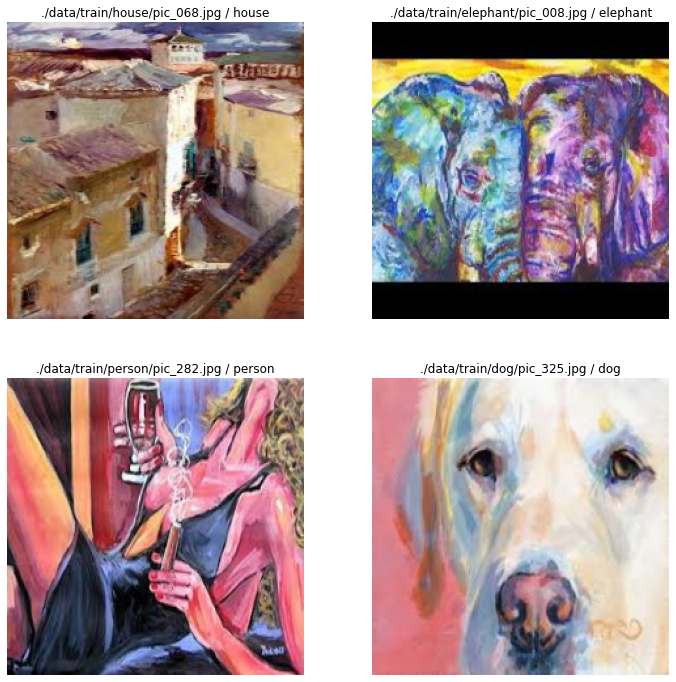

In [27]:
show_result(model, test_dataset, device)

# Train Fold 1

In [28]:
model = Net(args=args)

In [29]:
train_data = folded['fold1']['train'][0]
train_label = folded['fold1']['train'][1]

test_data = folded['fold1']['test'][0]
test_label = folded['fold1']['test'][1]

train_dataset = CustomDataset(train_data, train_label, transforms=transforms['train'])
test_dataset = CustomDataset(test_data, test_label, transforms=transforms['val'])

In [30]:
train_iter = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, drop_last=True)
test_iter = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)

In [31]:
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-8)

In [32]:
best_prec = 0
f = open("./ckpt/fold1/log.txt", "w")

for epochs in range(EPOCHS):
    train_loss, val_loss, prec = train_epoch(model, train_iter, test_iter, epochs, optimizer, device)
    scheduler.step()
    f.write(f"==========================\ntrain_loss:{train_loss}\nval_loss:{val_loss}\nprecision: {prec}\n")
    if prec>best_prec:
        torch.save(model.state_dict(), './ckpt/fold1/best.pth')
        best_prec = prec
    
f.close()

=========== START TRAIN EPOCH 0 ===========




=========== START VALID EPOCH 0 ===========




	class 0 PRECISION: 0.9291
	class 1 PRECISION: 0.8976
	class 2 PRECISION: 0.9194
	class 3 PRECISION: 0.9412
	class 4 PRECISION: 0.9684
	class 5 PRECISION: 0.9314
	class 6 PRECISION: 0.8475
		total precision: 0.9062
epoch 0 DONE.
=========== START TRAIN EPOCH 1 ===========




=========== START VALID EPOCH 1 ===========




	class 0 PRECISION: 0.9685
	class 1 PRECISION: 0.9515
	class 2 PRECISION: 0.9835
	class 3 PRECISION: 1.0000
	class 4 PRECISION: 0.9911
	class 5 PRECISION: 0.9507
	class 6 PRECISION: 0.9450
		total precision: 0.9643
epoch 1 DONE.
=========== START TRAIN EPOCH 2 ===========




=========== START VALID EPOCH 2 ===========




	class 0 PRECISION: 0.9731
	class 1 PRECISION: 0.9875
	class 2 PRECISION: 1.0000
	class 3 PRECISION: 1.0000
	class 4 PRECISION: 0.9826
	class 5 PRECISION: 0.9751
	class 6 PRECISION: 0.9781
		total precision: 0.9829
epoch 2 DONE.
=========== START TRAIN EPOCH 3 ===========




=========== START VALID EPOCH 3 ===========




	class 0 PRECISION: 0.9844
	class 1 PRECISION: 0.9812
	class 2 PRECISION: 0.9892
	class 3 PRECISION: 1.0000
	class 4 PRECISION: 1.0000
	class 5 PRECISION: 0.9948
	class 6 PRECISION: 0.9547
		total precision: 0.9814
epoch 3 DONE.
=========== START TRAIN EPOCH 4 ===========




=========== START VALID EPOCH 4 ===========




	class 0 PRECISION: 0.9884
	class 1 PRECISION: 0.9876
	class 2 PRECISION: 0.9947
	class 3 PRECISION: 1.0000
	class 4 PRECISION: 1.0000
	class 5 PRECISION: 1.0000
	class 6 PRECISION: 0.9906
		total precision: 0.9933
epoch 4 DONE.
=========== START TRAIN EPOCH 5 ===========




=========== START VALID EPOCH 5 ===========




	class 0 PRECISION: 0.9922
	class 1 PRECISION: 0.9938
	class 2 PRECISION: 0.9947
	class 3 PRECISION: 1.0000
	class 4 PRECISION: 1.0000
	class 5 PRECISION: 0.9949
	class 6 PRECISION: 0.9937
		total precision: 0.9948
epoch 5 DONE.
=========== START TRAIN EPOCH 6 ===========




=========== START VALID EPOCH 6 ===========




	class 0 PRECISION: 0.9886
	class 1 PRECISION: 0.9816
	class 2 PRECISION: 1.0000
	class 3 PRECISION: 1.0000
	class 4 PRECISION: 1.0000
	class 5 PRECISION: 1.0000
	class 6 PRECISION: 0.9875
		total precision: 0.9926
epoch 6 DONE.
=========== START TRAIN EPOCH 7 ===========




=========== START VALID EPOCH 7 ===========




	class 0 PRECISION: 0.9884
	class 1 PRECISION: 1.0000
	class 2 PRECISION: 0.9947
	class 3 PRECISION: 1.0000
	class 4 PRECISION: 1.0000
	class 5 PRECISION: 0.9949
	class 6 PRECISION: 0.9937
		total precision: 0.9948
epoch 7 DONE.
=========== START TRAIN EPOCH 8 ===========




=========== START VALID EPOCH 8 ===========




	class 0 PRECISION: 0.9962
	class 1 PRECISION: 1.0000
	class 2 PRECISION: 1.0000
	class 3 PRECISION: 1.0000
	class 4 PRECISION: 1.0000
	class 5 PRECISION: 1.0000
	class 6 PRECISION: 0.9937
		total precision: 0.9978
epoch 8 DONE.
=========== START TRAIN EPOCH 9 ===========




=========== START VALID EPOCH 9 ===========




	class 0 PRECISION: 1.0000
	class 1 PRECISION: 0.9877
	class 2 PRECISION: 0.9947
	class 3 PRECISION: 1.0000
	class 4 PRECISION: 1.0000
	class 5 PRECISION: 1.0000
	class 6 PRECISION: 0.9906
		total precision: 0.9955
epoch 9 DONE.


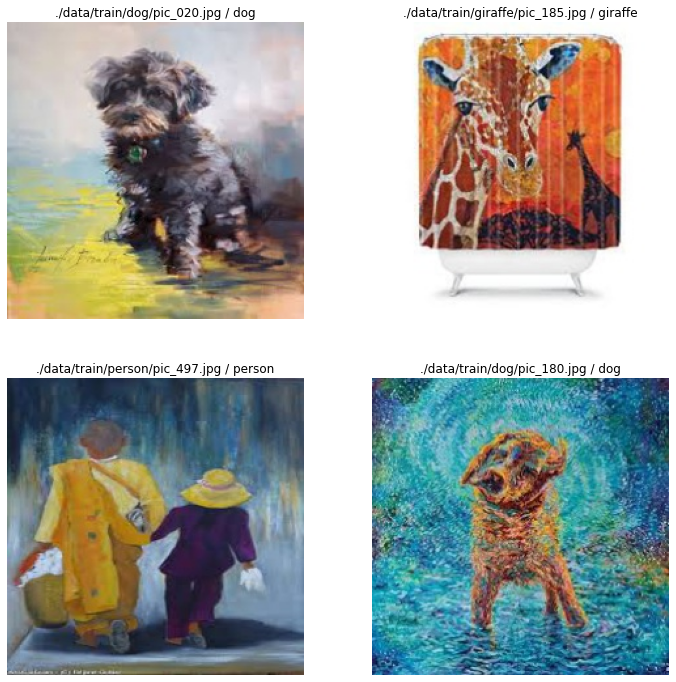

In [33]:
show_result(model, test_dataset, device)

# Train Fold 2

In [34]:
model = Net(args=args)

In [36]:
train_data = folded['fold2']['train'][0]
train_label = folded['fold2']['train'][1]

test_data = folded['fold2']['test'][0]
test_label = folded['fold2']['test'][1]

train_dataset = CustomDataset(train_data, train_label, transforms=transforms['train'])
test_dataset = CustomDataset(test_data, test_label, transforms=transforms['val'])

In [37]:
train_iter = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, drop_last=True)
test_iter = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)

In [38]:
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-8)

In [39]:
best_prec = 0
f = open("./ckpt/fold2/log.txt", "w")

for epochs in range(EPOCHS):
    train_loss, val_loss, prec = train_epoch(model, train_iter, test_iter, epochs, optimizer, device)
    scheduler.step()
    f.write(f"==========================\ntrain_loss:{train_loss}\nval_loss:{val_loss}\nprecision: {prec}\n")
    if prec>best_prec:
        torch.save(model.state_dict(), './ckpt/fold2/best.pth')
        best_prec = prec
    
f.close()

=========== START TRAIN EPOCH 0 ===========




=========== START VALID EPOCH 0 ===========




	class 0 PRECISION: 0.9474
	class 1 PRECISION: 0.8655
	class 2 PRECISION: 0.9149
	class 3 PRECISION: 0.9057
	class 4 PRECISION: 0.9474
	class 5 PRECISION: 0.8649
	class 6 PRECISION: 0.9397
		total precision: 0.9137
epoch 0 DONE.
=========== START TRAIN EPOCH 1 ===========




=========== START VALID EPOCH 1 ===========




	class 0 PRECISION: 0.9655
	class 1 PRECISION: 0.9618
	class 2 PRECISION: 0.9674
	class 3 PRECISION: 0.9623
	class 4 PRECISION: 0.9911
	class 5 PRECISION: 0.9366
	class 6 PRECISION: 0.9655
		total precision: 0.9628
epoch 1 DONE.
=========== START TRAIN EPOCH 2 ===========




=========== START VALID EPOCH 2 ===========




	class 0 PRECISION: 0.9664
	class 1 PRECISION: 0.9873
	class 2 PRECISION: 1.0000
	class 3 PRECISION: 0.9903
	class 4 PRECISION: 0.9835
	class 5 PRECISION: 0.9701
	class 6 PRECISION: 1.0000
		total precision: 0.9851
epoch 2 DONE.
=========== START TRAIN EPOCH 3 ===========




=========== START VALID EPOCH 3 ===========




	class 0 PRECISION: 0.9810
	class 1 PRECISION: 1.0000
	class 2 PRECISION: 0.9946
	class 3 PRECISION: 0.9906
	class 4 PRECISION: 0.9833
	class 5 PRECISION: 0.9898
	class 6 PRECISION: 0.9936
		total precision: 0.9903
epoch 3 DONE.
=========== START TRAIN EPOCH 4 ===========




=========== START VALID EPOCH 4 ===========




	class 0 PRECISION: 0.9810
	class 1 PRECISION: 0.9876
	class 2 PRECISION: 0.9947
	class 3 PRECISION: 0.9906
	class 4 PRECISION: 1.0000
	class 5 PRECISION: 0.9949
	class 6 PRECISION: 0.9968
		total precision: 0.9918
epoch 4 DONE.
=========== START TRAIN EPOCH 5 ===========




=========== START VALID EPOCH 5 ===========




	class 0 PRECISION: 0.9774
	class 1 PRECISION: 1.0000
	class 2 PRECISION: 1.0000
	class 3 PRECISION: 1.0000
	class 4 PRECISION: 0.9915
	class 5 PRECISION: 0.9948
	class 6 PRECISION: 0.9844
		total precision: 0.9903
epoch 5 DONE.
=========== START TRAIN EPOCH 6 ===========




=========== START VALID EPOCH 6 ===========




	class 0 PRECISION: 0.9924
	class 1 PRECISION: 0.9759
	class 2 PRECISION: 0.9947
	class 3 PRECISION: 1.0000
	class 4 PRECISION: 1.0000
	class 5 PRECISION: 1.0000
	class 6 PRECISION: 1.0000
		total precision: 0.9948
epoch 6 DONE.
=========== START TRAIN EPOCH 7 ===========




=========== START VALID EPOCH 7 ===========




	class 0 PRECISION: 0.9962
	class 1 PRECISION: 0.9878
	class 2 PRECISION: 1.0000
	class 3 PRECISION: 1.0000
	class 4 PRECISION: 1.0000
	class 5 PRECISION: 0.9949
	class 6 PRECISION: 0.9937
		total precision: 0.9955
epoch 7 DONE.
=========== START TRAIN EPOCH 8 ===========




=========== START VALID EPOCH 8 ===========




	class 0 PRECISION: 0.9924
	class 1 PRECISION: 1.0000
	class 2 PRECISION: 0.9947
	class 3 PRECISION: 1.0000
	class 4 PRECISION: 0.9915
	class 5 PRECISION: 1.0000
	class 6 PRECISION: 0.9968
		total precision: 0.9963
epoch 8 DONE.
=========== START TRAIN EPOCH 9 ===========




=========== START VALID EPOCH 9 ===========




	class 0 PRECISION: 1.0000
	class 1 PRECISION: 1.0000
	class 2 PRECISION: 1.0000
	class 3 PRECISION: 1.0000
	class 4 PRECISION: 1.0000
	class 5 PRECISION: 0.9949
	class 6 PRECISION: 0.9937
		total precision: 0.9978
epoch 9 DONE.


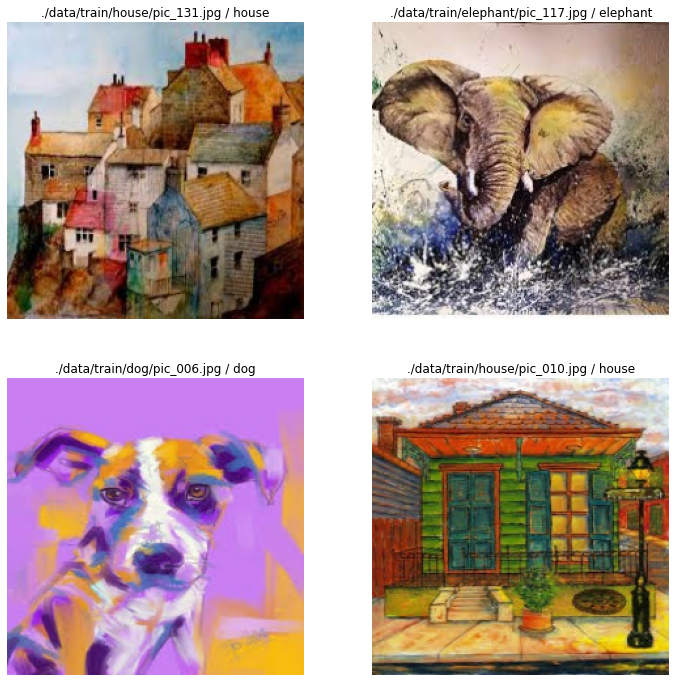

In [41]:
show_result(model, test_dataset, device)

# Train Fold 3

In [42]:
model = Net(args=args)

In [43]:
train_data = folded['fold3']['train'][0]
train_label = folded['fold3']['train'][1]

test_data = folded['fold3']['test'][0]
test_label = folded['fold3']['test'][1]

train_dataset = CustomDataset(train_data, train_label, transforms=transforms['train'])
test_dataset = CustomDataset(test_data, test_label, transforms=transforms['val'])

In [44]:
train_iter = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, drop_last=True)
test_iter = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)

In [45]:
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-8)

In [46]:
best_prec = 0
f = open("./ckpt/fold3/log.txt", "w")

for epochs in range(EPOCHS):
    train_loss, val_loss, prec = train_epoch(model, train_iter, test_iter, epochs, optimizer, device)
    scheduler.step()
    f.write(f"==========================\ntrain_loss:{train_loss}\nval_loss:{val_loss}\nprecision: {prec}\n")
    if prec>best_prec:
        torch.save(model.state_dict(), './ckpt/fold3/best.pth')
        best_prec = prec
    
f.close()

=========== START TRAIN EPOCH 0 ===========




=========== START VALID EPOCH 0 ===========




	class 0 PRECISION: 0.9565
	class 1 PRECISION: 0.8875
	class 2 PRECISION: 0.9553
	class 3 PRECISION: 0.9358
	class 4 PRECISION: 0.9510
	class 5 PRECISION: 0.9019
	class 6 PRECISION: 0.9174
		total precision: 0.9278
epoch 0 DONE.
=========== START TRAIN EPOCH 1 ===========




=========== START VALID EPOCH 1 ===========




	class 0 PRECISION: 0.9802
	class 1 PRECISION: 0.9872
	class 2 PRECISION: 0.9677
	class 3 PRECISION: 0.9810
	class 4 PRECISION: 0.9669
	class 5 PRECISION: 0.9646
	class 6 PRECISION: 0.9632
		total precision: 0.9717
epoch 1 DONE.
=========== START TRAIN EPOCH 2 ===========




=========== START VALID EPOCH 2 ===========




	class 0 PRECISION: 0.9921
	class 1 PRECISION: 0.9875
	class 2 PRECISION: 0.9840
	class 3 PRECISION: 0.9722
	class 4 PRECISION: 0.9833
	class 5 PRECISION: 0.9845
	class 6 PRECISION: 0.9782
		total precision: 0.9836
epoch 2 DONE.
=========== START TRAIN EPOCH 3 ===========




=========== START VALID EPOCH 3 ===========




	class 0 PRECISION: 0.9738
	class 1 PRECISION: 0.9938
	class 2 PRECISION: 0.9946
	class 3 PRECISION: 0.9722
	class 4 PRECISION: 1.0000
	class 5 PRECISION: 0.9948
	class 6 PRECISION: 0.9937
		total precision: 0.9888
epoch 3 DONE.
=========== START TRAIN EPOCH 4 ===========




=========== START VALID EPOCH 4 ===========




	class 0 PRECISION: 0.9961
	class 1 PRECISION: 1.0000
	class 2 PRECISION: 0.9947
	class 3 PRECISION: 1.0000
	class 4 PRECISION: 0.9917
	class 5 PRECISION: 0.9948
	class 6 PRECISION: 0.9906
		total precision: 0.9948
epoch 4 DONE.
=========== START TRAIN EPOCH 5 ===========




=========== START VALID EPOCH 5 ===========




	class 0 PRECISION: 0.9810
	class 1 PRECISION: 1.0000
	class 2 PRECISION: 1.0000
	class 3 PRECISION: 1.0000
	class 4 PRECISION: 1.0000
	class 5 PRECISION: 0.9948
	class 6 PRECISION: 0.9937
		total precision: 0.9940
epoch 5 DONE.
=========== START TRAIN EPOCH 6 ===========




=========== START VALID EPOCH 6 ===========




	class 0 PRECISION: 0.9962
	class 1 PRECISION: 1.0000
	class 2 PRECISION: 1.0000
	class 3 PRECISION: 1.0000
	class 4 PRECISION: 0.9835
	class 5 PRECISION: 1.0000
	class 6 PRECISION: 0.9968
		total precision: 0.9970
epoch 6 DONE.
=========== START TRAIN EPOCH 7 ===========




=========== START VALID EPOCH 7 ===========




	class 0 PRECISION: 1.0000
	class 1 PRECISION: 0.9939
	class 2 PRECISION: 0.9946
	class 3 PRECISION: 1.0000
	class 4 PRECISION: 1.0000
	class 5 PRECISION: 1.0000
	class 6 PRECISION: 0.9969
		total precision: 0.9978
epoch 7 DONE.
=========== START TRAIN EPOCH 8 ===========




=========== START VALID EPOCH 8 ===========




	class 0 PRECISION: 0.9924
	class 1 PRECISION: 1.0000
	class 2 PRECISION: 1.0000
	class 3 PRECISION: 0.9906
	class 4 PRECISION: 1.0000
	class 5 PRECISION: 0.9949
	class 6 PRECISION: 1.0000
		total precision: 0.9970
epoch 8 DONE.
=========== START TRAIN EPOCH 9 ===========




=========== START VALID EPOCH 9 ===========




	class 0 PRECISION: 0.9885
	class 1 PRECISION: 1.0000
	class 2 PRECISION: 1.0000
	class 3 PRECISION: 1.0000
	class 4 PRECISION: 1.0000
	class 5 PRECISION: 0.9949
	class 6 PRECISION: 1.0000
		total precision: 0.9970
epoch 9 DONE.


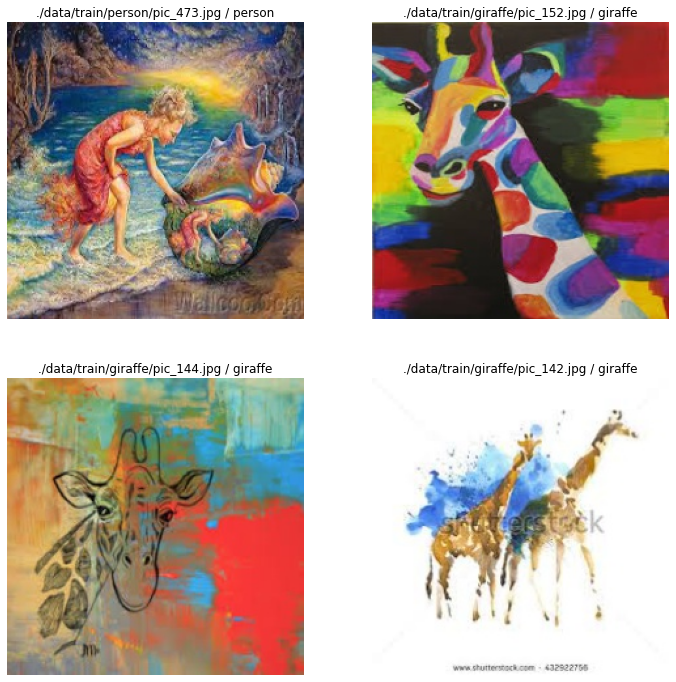

In [48]:
show_result(model, test_dataset, device)

# Train Fold 4

In [49]:
model = Net(args=args)

In [50]:
train_data = folded['fold4']['train'][0]
train_label = folded['fold4']['train'][1]

test_data = folded['fold4']['test'][0]
test_label = folded['fold4']['test'][1]

train_dataset = CustomDataset(train_data, train_label, transforms=transforms['train'])
test_dataset = CustomDataset(test_data, test_label, transforms=transforms['val'])

In [51]:
train_iter = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, drop_last=True)
test_iter = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)

In [52]:
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-8)

In [53]:
best_prec = 0
f = open("./ckpt/fold4/log.txt", "w")

for epochs in range(EPOCHS):
    train_loss, val_loss, prec = train_epoch(model, train_iter, test_iter, epochs, optimizer, device)
    scheduler.step()
    f.write(f"==========================\ntrain_loss:{train_loss}\nval_loss:{val_loss}\nprecision: {prec}\n")
    if prec>best_prec:
        torch.save(model.state_dict(), './ckpt/fold4/best.pth')
        best_prec = prec
    
f.close()

=========== START TRAIN EPOCH 0 ===========




=========== START VALID EPOCH 0 ===========




	class 0 PRECISION: 0.9715
	class 1 PRECISION: 0.9855
	class 2 PRECISION: 0.8974
	class 3 PRECISION: 0.9115
	class 4 PRECISION: 0.9469
	class 5 PRECISION: 0.9697
	class 6 PRECISION: 0.9150
		total precision: 0.9405
epoch 0 DONE.
=========== START TRAIN EPOCH 1 ===========




=========== START VALID EPOCH 1 ===========




	class 0 PRECISION: 0.9654
	class 1 PRECISION: 0.9747
	class 2 PRECISION: 0.9733
	class 3 PRECISION: 0.9550
	class 4 PRECISION: 1.0000
	class 5 PRECISION: 0.9698
	class 6 PRECISION: 0.9626
		total precision: 0.9695
epoch 1 DONE.
=========== START TRAIN EPOCH 2 ===========




=========== START VALID EPOCH 2 ===========




	class 0 PRECISION: 0.9923
	class 1 PRECISION: 1.0000
	class 2 PRECISION: 1.0000
	class 3 PRECISION: 1.0000
	class 4 PRECISION: 0.9831
	class 5 PRECISION: 0.9948
	class 6 PRECISION: 0.9782
		total precision: 0.9911
epoch 2 DONE.
=========== START TRAIN EPOCH 3 ===========




=========== START VALID EPOCH 3 ===========




	class 0 PRECISION: 0.9886
	class 1 PRECISION: 0.9937
	class 2 PRECISION: 1.0000
	class 3 PRECISION: 1.0000
	class 4 PRECISION: 0.9833
	class 5 PRECISION: 0.9949
	class 6 PRECISION: 0.9905
		total precision: 0.9926
epoch 3 DONE.
=========== START TRAIN EPOCH 4 ===========




=========== START VALID EPOCH 4 ===========




	class 0 PRECISION: 0.9961
	class 1 PRECISION: 0.9937
	class 2 PRECISION: 0.9839
	class 3 PRECISION: 1.0000
	class 4 PRECISION: 1.0000
	class 5 PRECISION: 1.0000
	class 6 PRECISION: 0.9753
		total precision: 0.9903
epoch 4 DONE.
=========== START TRAIN EPOCH 5 ===========




=========== START VALID EPOCH 5 ===========




	class 0 PRECISION: 0.9774
	class 1 PRECISION: 1.0000
	class 2 PRECISION: 0.9840
	class 3 PRECISION: 0.9907
	class 4 PRECISION: 0.9914
	class 5 PRECISION: 0.9898
	class 6 PRECISION: 0.9871
		total precision: 0.9874
epoch 5 DONE.
=========== START TRAIN EPOCH 6 ===========




=========== START VALID EPOCH 6 ===========




	class 0 PRECISION: 0.9923
	class 1 PRECISION: 1.0000
	class 2 PRECISION: 1.0000
	class 3 PRECISION: 1.0000
	class 4 PRECISION: 1.0000
	class 5 PRECISION: 1.0000
	class 6 PRECISION: 0.9968
		total precision: 0.9978
epoch 6 DONE.
=========== START TRAIN EPOCH 7 ===========




=========== START VALID EPOCH 7 ===========




	class 0 PRECISION: 1.0000
	class 1 PRECISION: 1.0000
	class 2 PRECISION: 1.0000
	class 3 PRECISION: 1.0000
	class 4 PRECISION: 1.0000
	class 5 PRECISION: 1.0000
	class 6 PRECISION: 0.9968
		total precision: 0.9993
epoch 7 DONE.
=========== START TRAIN EPOCH 8 ===========




=========== START VALID EPOCH 8 ===========




	class 0 PRECISION: 1.0000
	class 1 PRECISION: 1.0000
	class 2 PRECISION: 1.0000
	class 3 PRECISION: 1.0000
	class 4 PRECISION: 1.0000
	class 5 PRECISION: 1.0000
	class 6 PRECISION: 1.0000
		total precision: 1.0000
epoch 8 DONE.
=========== START TRAIN EPOCH 9 ===========




=========== START VALID EPOCH 9 ===========




	class 0 PRECISION: 0.9962
	class 1 PRECISION: 0.9939
	class 2 PRECISION: 1.0000
	class 3 PRECISION: 1.0000
	class 4 PRECISION: 0.9917
	class 5 PRECISION: 0.9896
	class 6 PRECISION: 0.9905
		total precision: 0.9940
epoch 9 DONE.


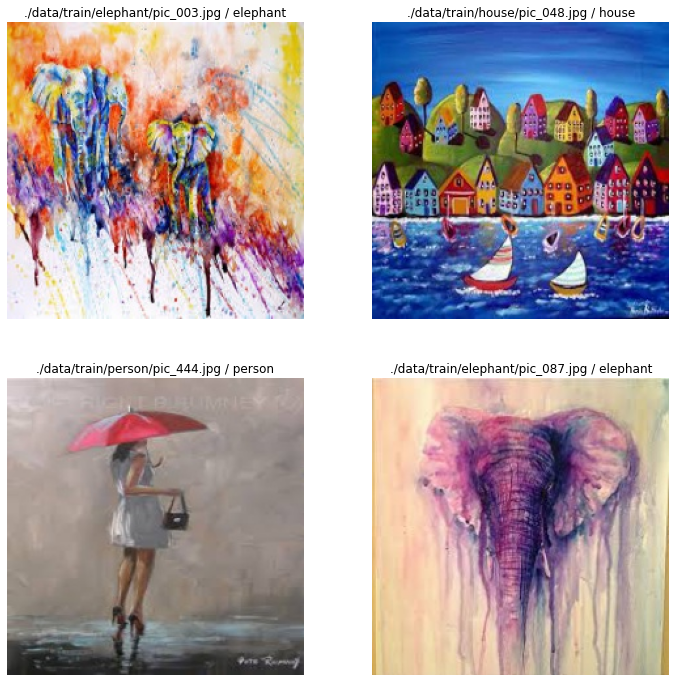

In [54]:
show_result(model, test_dataset, device)

# Inference

In [55]:
import pandas as pd

submission = pd.read_csv('./data/test_answer_sample.csv')

In [56]:
submission.head()

Unnamed: 0  answer value
0           0             0
1           1             0
2           2             0
3           3             0
4           4             0

In [57]:
data_paths = glob("./data/test/0/*")
test_dataset = CustomDataset(data_paths, None, True, transforms['val'])
test_iter = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)

In [58]:
models = [Net(args).to(device) for i in range(5)]

In [59]:
for i in range(5):
    models[i].load_state_dict(torch.load(f'./ckpt/fold{i}/best.pth', device))

In [66]:
for i in range(5):
    models[i].eval()

predictions = []

for i, b in enumerate(test_iter):
    imgs, _ = b
    imgs = imgs.to(device)
    logits = models[0](imgs)['logits']+models[1](imgs)['logits']+models[2](imgs)['logits']+models[3](imgs)['logits']+models[4](imgs)['logits']
    _, output = torch.max(logits, 1)
    for k in range(len(output)):
        predictions.append(int(output[k]))
    

In [67]:
submission['answer value'] = predictions

submission.to_csv('./submission_ensemble.csv', index=False)
print('test inference is done!')

test inference is done!


In [68]:
predictions = []

for i, b in enumerate(test_iter):
    imgs, _ = b
    imgs = imgs.to(device)
    logits = models[0](imgs)['logits']
    _, output = torch.max(logits, 1)
    for k in range(len(output)):
        predictions.append(int(output[k]))
    

In [69]:
submission['answer value'] = predictions

submission.to_csv('./submission_fold0.csv', index=False)
print('test inference is done!')

test inference is done!
